# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py # to open the .h5 files
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from IPython.display import clear_output

import itk
# !pip install itk
clear_output()
print('itk pip install done.')

print('All librairies sucessfully imported.')

itk pip install done.
All librairies sucessfully imported.


In [3]:
# import data

PATH_COLAB = '/content/drive/MyDrive/6_anevrism_segmentation/challenge_dataset.zip'
PATH_DEVICE = './challenge_dataset/'

try:
    from google.colab import drive
    print('Working on Colab')
    
    # connect your drive to the session
    drive.mount('/content/drive')

    # unzip data into the colab session
    ! unzip $PATH_COLAB
    
    # clear cell output
    clear_output()

    print('Data imported in Colab session.')
    
except:
    print('Working on your device.')
    
    data_exists = os.path.exists(PATH_DEVICE)
    
    if data_exists:
        print(f"Dataset found on device at : '{PATH_DEVICE}.'") 
    else:
        raise FileNotFoundError(f"Data folder not found at '{PATH_DEVICE}'")

Working on your device.
Dataset found on device at : './challenge_dataset/.'


# Data viz

In [4]:
# get file names in the folder
PATH_DATASET = 'challenge_dataset'

file_names = os.listdir(PATH_DATASET)
N = len(file_names)
print('nb elements :', N)
print(file_names[:10])

nb elements : 103
['scan_87.h5', 'scan_73.h5', 'scan_81.h5', 'scan_75.h5', 'scan_13.h5', 'scan_4.h5', 'scan_5.h5', 'scan_62.h5', 'scan_50.h5', 'scan_36.h5']


In [5]:
# check a specific file
f = h5py.File(f'{PATH_DATASET}/scan_18.h5', 'r')
print(f.keys())

X, Y = np.array(f['raw']), np.array(f['label'])
print(f'shape X : {X.shape}, shape Y : {Y.shape}')

<KeysViewHDF5 ['label', 'raw']>
shape X : (64, 192, 192), shape Y : (64, 192, 192)


In [6]:
np.unique(Y)

array([0, 1], dtype=uint8)

In [7]:
# Define a function to visualize the data
def explore_3dimage(i, j ,k):
    fig,ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].imshow(X[i, :, :], cmap='gray')
    ax[0].imshow(Y[i, :, :], cmap='jet', alpha=0.4)
    ax[0].set_title(f'Slice YZ')
    ax[0].axis('off')

    ax[1].imshow(X[:, j, :], cmap='gray')
    ax[1].imshow(Y[:, j, :], cmap='jet', alpha=0.4)
    ax[1].set_title(f'Slice XZ')
    ax[1].axis('off')
    
    ax[2].imshow(X[:, :, k], cmap='gray')
    ax[2].imshow(Y[:, :, k], cmap='jet', alpha=0.4)
    ax[2].set_title(f'Slice XY')
    ax[2].axis('off')

    plt.show()
    
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, 
         i=(0, X.shape[0] - 1), 
         j=(0, X.shape[1] - 1), 
         k=(0, X.shape[2] - 1));

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=95, description='j', max=1…

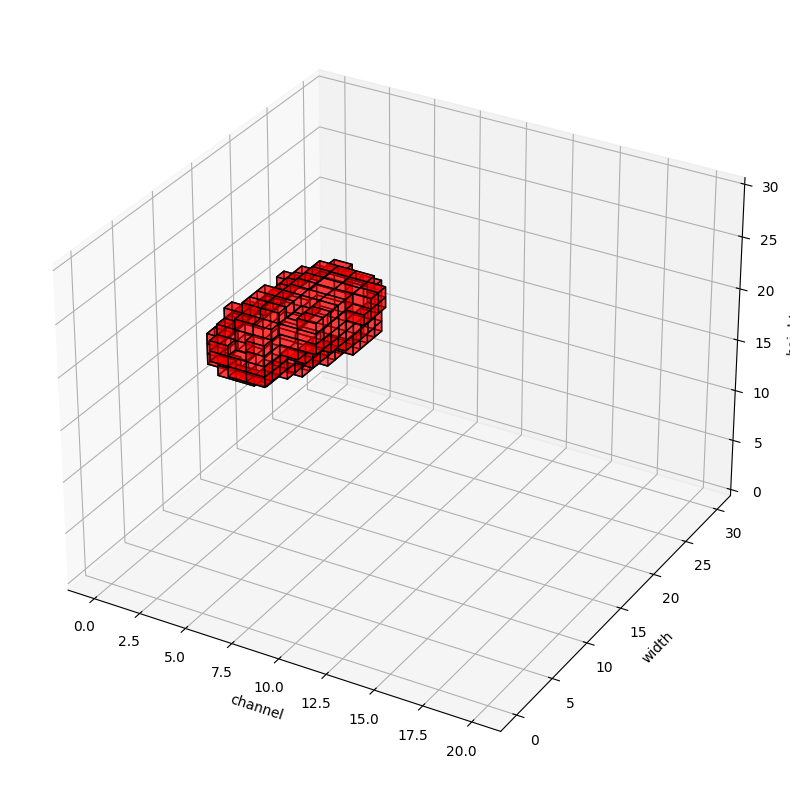

In [8]:
# plot the segmented zone 
# we make the assumption that the aneurysm is centered in the original image
xmin, xmax = 30, 50
ymin, ymax = 80, 110

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(Y[xmin:xmax, ymin:ymax, ymin:ymax], color='r', edgecolor='k', alpha=0.5)
ax.set(xlabel='channel', ylabel='width', zlabel='height')

plt.show()

## Voxels to mesh using trimesh

To obtain the mesh from the voxels, we use the **marching cubes** algorithm to approxime a 3D voxelized object by a polygon.
If you are interested about how the algorithm work, please refer to [this article](https://medium.com/zeg-ai/voxel-to-mesh-conversion-marching-cube-algorithm-43dbb0801359).

For our implementation, we will use an already implemented function in the [**trimesh** library](https://github.com/mikedh/trimesh).

### Trimesh installation
In your terminal using pip :
```bash
pip install trimesh
```

If you get some troubleshooting using the above command, please try to install the library globally (will require sudo privileges) using :
```bash
sudo -H pip install trimesh
```

In [21]:
import trimesh


mesh = trimesh.voxel.ops.matrix_to_marching_cubes(Y)

print(type(mesh))

<class 'trimesh.base.Trimesh'>


## Basic triangular mesh using label voxels

In [27]:
mesh.show()

## Convex hull of the aneurysm

In [28]:
convex_mesh = mesh.convex_hull

In [29]:
convex_mesh.show()

## Elements du maillage

In [36]:
vertices = mesh.vertices

In [38]:
vertices

TrackedArray([[28.5, 94. , 93. ],
              [29. , 93.5, 93. ],
              [29. , 94. , 92.5],
              ...,
              [36.5, 98. , 99. ],
              [36.5, 99. , 98. ],
              [36.5, 99. , 99. ]])

In [46]:
faces = mesh.faces

In [48]:
faces

TrackedArray([[  2,   1,   0],
              [  3,   0,   1],
              [  2,   0,   4],
              ...,
              [406, 394, 396],
              [406, 396, 407],
              [407, 396, 389]])

## Vertices plot using plt

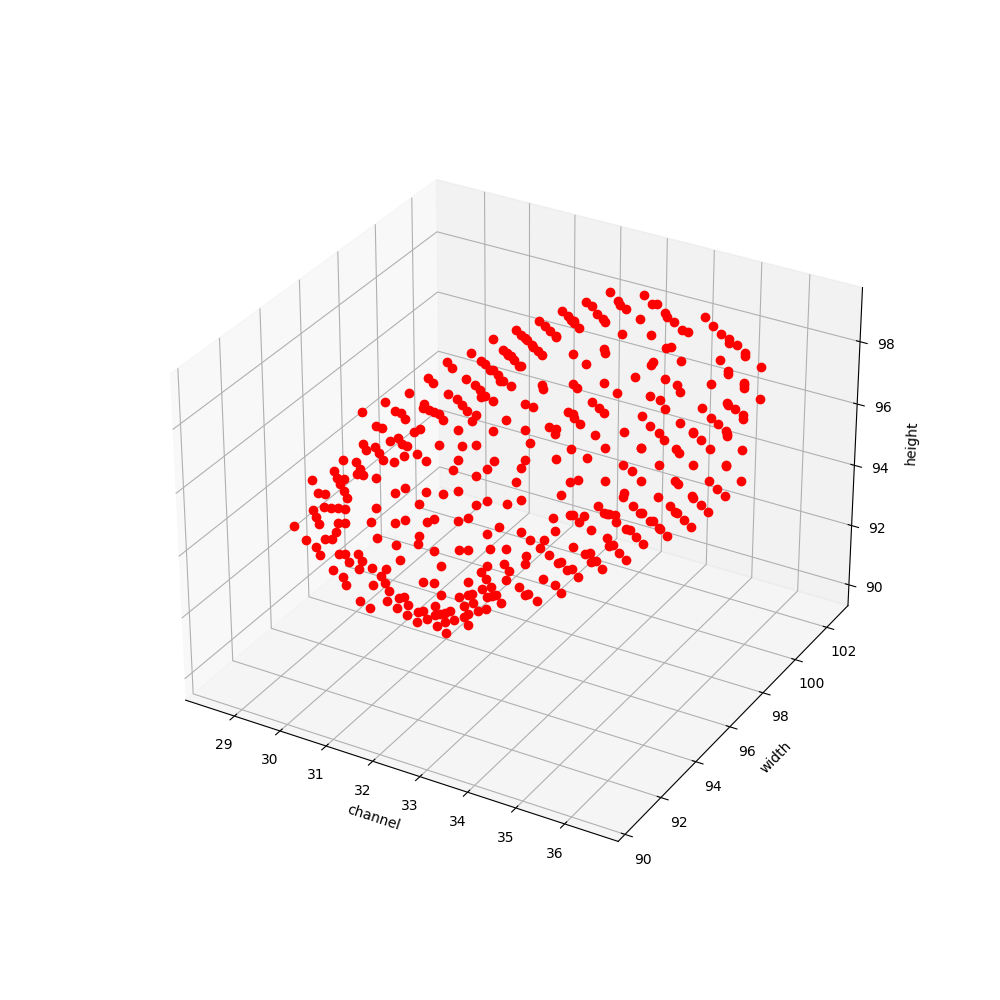

In [45]:
# plot the segmented zone 
# we make the assumption that the aneurysm is centered in the original image
xmin, xmax = 20, 50
ymin, ymax = 80, 110

%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(vertices[:,0], vertices[:,1], vertices[:,2], marker = "o",color='r', linewidth = 0)
ax.f
ax.set(xlabel='channel', ylabel='width', zlabel='height')

plt.show()

## Vertices and faces plot using matplotlib

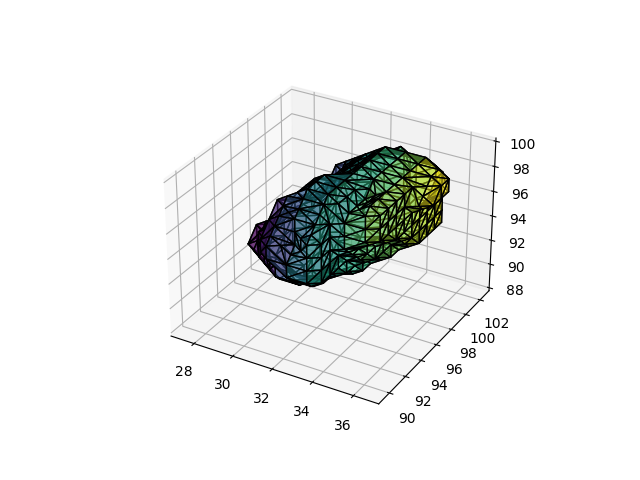

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

v = vertices

f = faces

C = np.arange(len(faces))


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

norm = plt.Normalize(C.min(), C.max())
colors = plt.cm.viridis(norm(C))

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black", alpha=0.5)
ax.add_collection(pc)


mins = v.min(axis = 0).astype(int) - 1
maxs = v.max(axis = 0).astype(int) + 1

#ax.voxels(Y[mins[0]: maxs[0], mins[1]: maxs[1], mins[2]: maxs[2]], color='r', edgecolor='k', alpha=0.5)
#ax.set(xlabel='channel', ylabel='width', zlabel='height')


ax.set_xlim([mins[0], maxs[0]])
ax.set_ylim([mins[1], maxs[1]])
ax.set_zlim([mins[2], maxs[2]])


plt.show()